# Customer Segmentation

### Toan Diec 300320364

###  Load the python library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score
import datetime as dt
from sklearn.cluster import MiniBatchKMeans




import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Function used in the project

In [2]:
#function to check duplicate value in column
def duplicateRowsDataFrame(df, column):
    return df[df.duplicated(subset=[column], keep=False)].sort_values(column, ascending=False) 

In [3]:
#function to take only top values in column
def takeTopValues(df_column, n, top_n_value=None):
    if top_n_value:
        top_n = top_n_value
    else:
        z = pd.DataFrame(df_column).copy()
        z['val'] = 1
        z.columns = ['key', 'val']
        top_n = z.groupby('key').size().sort_values(ascending=False)[:n]
        top_n = pd.DataFrame(top_n).reset_index()
        top_n = list(top_n.key.values)
    df_column = df_column.apply(lambda y: y if y in top_n else np.NaN)
        
    return df_column

In [4]:
feature_selection= []
feature_transformation = []
model_used = []
calinski_harabasz_score_lst = []
silhouette_score_lst = []

def addResult(feature_select,transform,model, cal_score, sil_score):
    feature_selection.append(feature_select)
    feature_transformation.append(transform)
    model_used.append(model)
    calinski_harabasz_score_lst.append(cal_score)
    silhouette_score_lst.append(sil_score)

In [5]:
def findElbow(df):
    sse = {}

    # Fit KMeans and calculate SSE for each k
    for k in range(1, 10):
  
        # Initialize KMeans with k clusters
        kmeans = KMeans(n_clusters=k, random_state=1)
        # Fit KMeans on the normalized dataset
        kmeans.fit(df)

        sse[k] = kmeans.inertia_
    
    #plot the Elbow
    plt.figure(figsize=(12,8))
    plt.title('The Elbow Method')
    plt.xlabel('k'); 
    plt.ylabel('Sum of squared errors')
    sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
    plt.show()

In [6]:
def kmeans(number_of_cluster,data_used,feature_selection,transformation):
    kmeans = KMeans(n_clusters=number_of_cluster, random_state=1,algorithm='auto',init='k-means++', 
                     n_init=10, 
                     max_iter=1000, 
                     tol=0.0001, 
                     precompute_distances='auto', 
                     verbose=0)
    model_title = 'Kmean, k =' + str(number_of_cluster)

    # Compute k-means clustering on pre-processed data
    label = kmeans.fit(data_used)

    # Extract cluster labels from labels_ attribute
    cluster_labels = kmeans.labels_
    calinski_score = calinski_harabasz_score(data_used, cluster_labels)
    silhoue_score = silhouette_score(data_used, cluster_labels)

    print("kmeans,", number_of_cluster, "clusters: ,  ""calinski_harabaz_score" ,calinski_score,
      "silhouette_score", silhoue_score,'\n' )

    addResult(feature_selection, transformation, model_title,calinski_score,silhoue_score )
    
    return cluster_labels

In [7]:
def miniBatchKM(number_of_cluster,data_used,feature_selection,transformation):
    minibatchm = MiniBatchKMeans(init='k-means++', n_clusters=number_of_cluster, batch_size=5*number_of_cluster,
                    n_init=10, max_no_improvement=20, verbose=0,
                    random_state=0)
    model_title = 'Mini Batch Kmean, k =' + str(number_of_cluster)
    # Compute k-means clustering on pre-processed data
    label = minibatchm.fit(data_used)
    # Extract cluster labels from labels_ attribute
    minibatch_labels = minibatchm.labels_
    calinski_score = calinski_harabasz_score(data_used, minibatch_labels)
    silhoue_score = silhouette_score(data_used, minibatch_labels)

    print("Mini Batch kmeans,", number_of_cluster, "clusters: ,  ""calinski_harabaz_score" ,calinski_score,
      "silhouette_score", silhoue_score,'\n' )

    addResult(feature_selection, transformation, model_title,calinski_score,silhoue_score )


In [8]:
def create_customer_segment(df):
    if df['RFM_Score'] >= 9:
        return 'High'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Middle'
    else:
        return 'Low'

In [9]:
#function to create linear regression and add to summary list 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scaleFeature(features):
    ms = MinMaxScaler()
    scaled_features = ms.fit_transform(features)

    scaled_df_features = pd.DataFrame(scaled_features, columns = features.columns)
    return scaled_df_features

def standardScaler (df):
    ss = StandardScaler()
    scaled_df = ss.fit_transform(df)
    scaled_df2 = pd.DataFrame(scaled_df, columns = df.columns)
    return scaled_df2



def PolyTransform(df):
    pf = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
    fit_pf = pf.fit(df)

    poly = pd.DataFrame(pf.transform(df), columns = fit_pf.get_feature_names(df.columns))
    return poly

def LogTransform(df):
    features_log = df.copy()
    for column in features_log.columns:
        features_log[column+'_log1p'] = features_log[column].apply(lambda x: np.log1p(x))
    return features_log

### Read the dataset

In [10]:
df = pd.read_csv('uncleaned_data.csv')

In [11]:
df.head()

,Customer City,Customer Id,Customer State,Customer Unique Id,Order Id,Order Item Id,Order Purchase Timestamp,Order Status,Payment Type,Product Category Name English,Product Id,Seller Id,Freight Value,Payment Installments,Payment Sequential,Payment Value,Price
0,campos dos goytacazes,3ce436f183e68e07877b285a838db11a,RJ,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,1,9/13/2017 8:59,delivered,credit_card,cool_stuff,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,13.29,2,1,72.19,58.90
1,santa fe do sul,f6dd3ec061db4e3987629fe6b26e5cce,SP,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,1,4/26/2017 10:53,delivered,credit_card,pet_shop,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,19.93,3,1,259.83,239.90
2,para de minas,6489ae5e4333f3693df5ad4372dab6d3,MG,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,1,1/14/2018 14:33,delivered,credit_card,furniture_decor,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,17.87,5,1,216.87,199.00
3,atibaia,d4eb9395c8c0431ee92fce09860c5a06,SP,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,1,8/8/2018 10:00,delivered,credit_card,perfumery,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.79,2,1,25.78,12.99
4,varzea paulista,58dbd0b2d70206bf40e62cd34e84d795,SP,64b576fb70d441e8f1b2d7d446e483c5,00042b26cf59d7ce69dfabb4e55b4fd9,1,2/4/2017 13:57,delivered,credit_card,garden_tools,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,18.14,3,1,218.04,199.90


### Feature Engineering

In [12]:
##replace white space in columns name with _
df.columns = [x.replace(" ","_") for x in df.columns] 
df.columns

Index(['Customer_City', 'Customer_Id', 'Customer_State', 'Customer_Unique_Id',
       'Order_Id', 'Order_Item_Id', 'Order_Purchase_Timestamp', 'Order_Status',
       'Payment_Type', 'Product_Category_Name_English', 'Product_Id',
       'Seller_Id', 'Freight_Value', 'Payment_Installments',
       'Payment_Sequential', 'Payment_Value', 'Price'],
      dtype='object')

In [13]:
df.shape

(117601, 17)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Customer_City                  117601 non-null  object 
 1   Customer_Id                    117601 non-null  object 
 2   Customer_State                 117601 non-null  object 
 3   Customer_Unique_Id             117601 non-null  object 
 4   Order_Id                       117601 non-null  object 
 5   Order_Item_Id                  117601 non-null  int64  
 6   Order_Purchase_Timestamp       117601 non-null  object 
 7   Order_Status                   117601 non-null  object 
 8   Payment_Type                   117601 non-null  object 
 9   Product_Category_Name_English  115878 non-null  object 
 10  Product_Id                     117601 non-null  object 
 11  Seller_Id                      117601 non-null  object 
 12  Freight_Value                 

In [15]:
#Check duplicate value in Order_Id column
duplicateRowsDataFrame(df, 'Order_Id')


,Customer_City,Customer_Id,Customer_State,Customer_Unique_Id,Order_Id,Order_Item_Id,Order_Purchase_Timestamp,Order_Status,Payment_Type,Product_Category_Name_English,Product_Id,Seller_Id,Freight_Value,Payment_Installments,Payment_Sequential,Payment_Value,Price
117594,serra talhada,4d3abb73ceb86353aeadbe698aa9d5cb,PE,f736308cd9952b33b90b9fe94da9c8f5,fffb9224b6fc7c43ebb0904318b10b5f,4,10/27/2017 16:51,delivered,boleto,watches_gifts,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,34.19,1,1,356.76,55.00
117593,serra talhada,4d3abb73ceb86353aeadbe698aa9d5cb,PE,f736308cd9952b33b90b9fe94da9c8f5,fffb9224b6fc7c43ebb0904318b10b5f,3,10/27/2017 16:51,delivered,boleto,watches_gifts,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,34.19,1,1,356.76,55.00
117592,serra talhada,4d3abb73ceb86353aeadbe698aa9d5cb,PE,f736308cd9952b33b90b9fe94da9c8f5,fffb9224b6fc7c43ebb0904318b10b5f,2,10/27/2017 16:51,delivered,boleto,watches_gifts,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,34.19,1,1,356.76,55.00
117591,serra talhada,4d3abb73ceb86353aeadbe698aa9d5cb,PE,f736308cd9952b33b90b9fe94da9c8f5,fffb9224b6fc7c43ebb0904318b10b5f,1,10/27/2017 16:51,delivered,boleto,watches_gifts,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,34.19,1,1,356.76,55.00
117586,joao pessoa,6c1e92a209dbf868706caa831090941e,PB,028c09f007292c4e3a3b10d296e47987,fff8287bbae429a99bb7e8c21d151c41,2,3/17/2018 12:11,delivered,credit_card,computers_accessories,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,48.14,4,1,456.28,180.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,goiania,2e45292979b9b2700ea09560eeb0f803,GO,bb8a37225e0279ac8a274c9765617eaf,00143d0f86d6fbd9f9b38ab440ac16f5,3,10/16/2017 15:29,delivered,credit_card,sports_leisure,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,15.10,1,1,109.29,21.33
33,goiania,2e45292979b9b2700ea09560eeb0f803,GO,bb8a37225e0279ac8a274c9765617eaf,00143d0f86d6fbd9f9b38ab440ac16f5,2,10/16/2017 15:29,delivered,credit_card,sports_leisure,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,15.10,1,1,109.29,21.33
32,goiania,2e45292979b9b2700ea09560eeb0f803,GO,bb8a37225e0279ac8a274c9765617eaf,00143d0f86d6fbd9f9b38ab440ac16f5,1,10/16/2017 15:29,delivered,credit_card,sports_leisure,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,15.10,1,1,109.29,21.33
14,jandira,2355af7c75e7c98b43a87b2a7f210dc5,SP,9e4159995424971423b98c4a8bc11529,0008288aa423d2a3f00fcb17cd7d8719,2,2/13/2018 22:10,delivered,boleto,garden_tools,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,13.37,1,1,126.54,49.90


In [16]:
#create a new dataframe
df1 =pd.DataFrame(df.groupby('Order_Id')['Order_Item_Id'].sum()).merge(df.groupby('Order_Id')['Price','Freight_Value'].first(),
                                  on='Order_Id')

In [17]:
df1

,Order_Item_Id,Price,Freight_Value
Order_Id,,,
00010242fe8c5a6d1ba2dd792cb16214,1,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,1,239.90,19.93
000229ec398224ef6ca0657da4fc703e,1,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,1,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,18.14
...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1,299.99,43.41
fffcd46ef2263f404302a634eb57f7eb,1,350.00,36.53
fffce4705a9662cd70adb13d4a31832d,1,99.90,16.95


In [18]:
df1.reset_index()

,Order_Id,Order_Item_Id,Price,Freight_Value
0,00010242fe8c5a6d1ba2dd792cb16214,1,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,18.14
...,...,...,...,...
98660,fffc94f6ce00a00581880bf54a75a037,1,299.99,43.41
98661,fffcd46ef2263f404302a634eb57f7eb,1,350.00,36.53
98662,fffce4705a9662cd70adb13d4a31832d,1,99.90,16.95
98663,fffe18544ffabc95dfada21779c9644f,1,55.99,8.72


In [19]:
#left join the new dataframe with df at the beginning using 'Order_Id'
df2 = pd.merge(df1, df, how= 'left', on =['Order_Id'])

In [20]:
df2.shape

(117601, 20)

In [21]:
duplicateRowsDataFrame(df2, 'Order_Id')


,Order_Id,Order_Item_Id_x,Price_x,Freight_Value_x,Customer_City,Customer_Id,Customer_State,Customer_Unique_Id,Order_Item_Id_y,Order_Purchase_Timestamp,Order_Status,Payment_Type,Product_Category_Name_English,Product_Id,Seller_Id,Freight_Value_y,Payment_Installments,Payment_Sequential,Payment_Value,Price_y
117594,fffb9224b6fc7c43ebb0904318b10b5f,10,55.00,34.19,serra talhada,4d3abb73ceb86353aeadbe698aa9d5cb,PE,f736308cd9952b33b90b9fe94da9c8f5,4,10/27/2017 16:51,delivered,boleto,watches_gifts,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,34.19,1,1,356.76,55.00
117593,fffb9224b6fc7c43ebb0904318b10b5f,10,55.00,34.19,serra talhada,4d3abb73ceb86353aeadbe698aa9d5cb,PE,f736308cd9952b33b90b9fe94da9c8f5,3,10/27/2017 16:51,delivered,boleto,watches_gifts,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,34.19,1,1,356.76,55.00
117592,fffb9224b6fc7c43ebb0904318b10b5f,10,55.00,34.19,serra talhada,4d3abb73ceb86353aeadbe698aa9d5cb,PE,f736308cd9952b33b90b9fe94da9c8f5,2,10/27/2017 16:51,delivered,boleto,watches_gifts,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,34.19,1,1,356.76,55.00
117591,fffb9224b6fc7c43ebb0904318b10b5f,10,55.00,34.19,serra talhada,4d3abb73ceb86353aeadbe698aa9d5cb,PE,f736308cd9952b33b90b9fe94da9c8f5,1,10/27/2017 16:51,delivered,boleto,watches_gifts,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,34.19,1,1,356.76,55.00
117586,fff8287bbae429a99bb7e8c21d151c41,3,180.00,48.14,joao pessoa,6c1e92a209dbf868706caa831090941e,PB,028c09f007292c4e3a3b10d296e47987,2,3/17/2018 12:11,delivered,credit_card,computers_accessories,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,48.14,4,1,456.28,180.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,00143d0f86d6fbd9f9b38ab440ac16f5,6,21.33,15.10,goiania,2e45292979b9b2700ea09560eeb0f803,GO,bb8a37225e0279ac8a274c9765617eaf,3,10/16/2017 15:29,delivered,credit_card,sports_leisure,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,15.10,1,1,109.29,21.33
32,00143d0f86d6fbd9f9b38ab440ac16f5,6,21.33,15.10,goiania,2e45292979b9b2700ea09560eeb0f803,GO,bb8a37225e0279ac8a274c9765617eaf,1,10/16/2017 15:29,delivered,credit_card,sports_leisure,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,15.10,1,1,109.29,21.33
33,00143d0f86d6fbd9f9b38ab440ac16f5,6,21.33,15.10,goiania,2e45292979b9b2700ea09560eeb0f803,GO,bb8a37225e0279ac8a274c9765617eaf,2,10/16/2017 15:29,delivered,credit_card,sports_leisure,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,15.10,1,1,109.29,21.33
14,0008288aa423d2a3f00fcb17cd7d8719,3,49.90,13.37,jandira,2355af7c75e7c98b43a87b2a7f210dc5,SP,9e4159995424971423b98c4a8bc11529,2,2/13/2018 22:10,delivered,boleto,garden_tools,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,13.37,1,1,126.54,49.90


In [22]:
df2.drop_duplicates(keep ='first', inplace=True,subset='Order_Id')

In [23]:
df2.drop(['Price_y','Order_Item_Id_y','Freight_Value_y'], axis =1,inplace = True)

In [24]:
df2.rename(columns = {'Order_Item_Id_x':'Number_Order_Item', 'Price_x':'Price', 'Freight_Value_x': 'Freight_Value'}, inplace = True)

In [25]:
df2

,Order_Id,Number_Order_Item,Price,Freight_Value,Customer_City,Customer_Id,Customer_State,Customer_Unique_Id,Order_Purchase_Timestamp,Order_Status,Payment_Type,Product_Category_Name_English,Product_Id,Seller_Id,Payment_Installments,Payment_Sequential,Payment_Value
0,00010242fe8c5a6d1ba2dd792cb16214,1,58.90,13.29,campos dos goytacazes,3ce436f183e68e07877b285a838db11a,RJ,871766c5855e863f6eccc05f988b23cb,9/13/2017 8:59,delivered,credit_card,cool_stuff,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2,1,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,239.90,19.93,santa fe do sul,f6dd3ec061db4e3987629fe6b26e5cce,SP,eb28e67c4c0b83846050ddfb8a35d051,4/26/2017 10:53,delivered,credit_card,pet_shop,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,3,1,259.83
2,000229ec398224ef6ca0657da4fc703e,1,199.00,17.87,para de minas,6489ae5e4333f3693df5ad4372dab6d3,MG,3818d81c6709e39d06b2738a8d3a2474,1/14/2018 14:33,delivered,credit_card,furniture_decor,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,5,1,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,12.99,12.79,atibaia,d4eb9395c8c0431ee92fce09860c5a06,SP,af861d436cfc08b2c2ddefd0ba074622,8/8/2018 10:00,delivered,credit_card,perfumery,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2,1,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,18.14,varzea paulista,58dbd0b2d70206bf40e62cd34e84d795,SP,64b576fb70d441e8f1b2d7d446e483c5,2/4/2017 13:57,delivered,credit_card,garden_tools,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,3,1,218.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117596,fffc94f6ce00a00581880bf54a75a037,1,299.99,43.41,sao luis,b51593916b4b8e0d6f66f2ae24f2673d,MA,0c9aeda10a71f369396d0c04dce13a64,4/23/2018 13:57,delivered,boleto,housewares,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,1,1,343.40
117597,fffcd46ef2263f404302a634eb57f7eb,1,350.00,36.53,curitiba,84c5d4fbaf120aae381fad077416eaa0,PR,0da9fe112eae0c74d3ba1fe16de0988b,7/14/2018 10:26,delivered,boleto,computers_accessories,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,1,1,386.53
117598,fffce4705a9662cd70adb13d4a31832d,1,99.90,16.95,sao paulo,29309aa813182aaddc9b259e31b870e6,SP,cd79b407828f02fdbba457111c38e4c4,10/23/2017 17:07,delivered,credit_card,sports_leisure,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,3,1,116.85
117599,fffe18544ffabc95dfada21779c9644f,1,55.99,8.72,vinhedo,b5e6afd5a41800fdf401e0272ca74655,SP,eb803377c9315b564bdedad672039306,8/14/2017 23:02,delivered,credit_card,computers_accessories,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,3,1,64.71


In [26]:
df2.shape

(98665, 17)

In [27]:
df2.Customer_State.value_counts()

SP    41374
RJ    12762
MG    11544
RS     5432
PR     4998
SC     3612
BA     3358
DF     2125
ES     2025
GO     2007
PE     1648
CE     1327
PA      970
MT      903
MA      740
MS      709
PB      532
PI      493
RN      482
AL      411
SE      345
TO      279
RO      247
AM      147
AC       81
AP       68
RR       46
Name: Customer_State, dtype: int64

In [28]:
#take the top 12 state where majority of customer are
df2.Customer_State =takeTopValues(df2.Customer_State,12)

In [29]:
df2.Customer_State.value_counts()

SP    41374
RJ    12762
MG    11544
RS     5432
PR     4998
SC     3612
BA     3358
DF     2125
ES     2025
GO     2007
PE     1648
CE     1327
Name: Customer_State, dtype: int64

In [30]:
df2.shape

(98665, 17)

In [31]:
df2.isnull().sum()

Order_Id                            0
Number_Order_Item                   0
Price                               0
Freight_Value                       0
Customer_City                       0
Customer_Id                         0
Customer_State                   6453
Customer_Unique_Id                  0
Order_Purchase_Timestamp            0
Order_Status                        0
Payment_Type                        0
Product_Category_Name_English    1437
Product_Id                          0
Seller_Id                           0
Payment_Installments                0
Payment_Sequential                  0
Payment_Value                       0
dtype: int64

In [32]:
df2 = df2.dropna()

In [33]:
#Create a new category column for Customer_City Code
df2.Customer_City = pd.Categorical(df2.Customer_City)
df2['Customer_City_Code'] = df2.Customer_City.cat.codes

#Create a new category column for Order_Status Code
df2.Order_Status = pd.Categorical(df2.Order_Status)
df2['Order_Status_Code'] = df2.Order_Status.cat.codes

#Create a new category column for Payment_Type Code
df2.Payment_Type = pd.Categorical(df2.Payment_Type)
df2['Payment_Type_Code'] = df2.Payment_Type.cat.codes

#Create a new category column for Customer_State Code
df2.Customer_State = pd.Categorical(df2.Customer_State)
df2['Customer_State_Code'] = df2.Customer_State.cat.codes

df2.Order_Id = pd.Categorical(df2.Order_Id)
df2['Order_Id_Code'] = df2.Order_Id.cat.codes

df2.Customer_Unique_Id = pd.Categorical(df2.Customer_Unique_Id)
df2['Customer_Unique_Id_Code'] = df2.Customer_Unique_Id.cat.codes

df2.Order_Id = pd.Categorical(df2.Order_Id)
df2['Order_Id_Code'] = df2.Order_Id.cat.codes

df2.Product_Id = pd.Categorical(df2.Product_Id)
df2['Product_Id_Code'] = df2.Product_Id.cat.codes

df2.Seller_Id = pd.Categorical(df2.Seller_Id)
df2['Seller_Id_Code'] = df2.Seller_Id.cat.codes

df2.Product_Category_Name_English = pd.Categorical(df2.Product_Category_Name_English)
df2['Product_Category_Name_English_Code'] = df2.Product_Category_Name_English.cat.codes

df2.reset_index(drop = True)
df2.drop(columns = ['Order_Id','Customer_Unique_Id','Product_Id','Seller_Id','Product_Category_Name_English'],axis=1 , inplace = True)
df2

,Number_Order_Item,Price,Freight_Value,Customer_City,Customer_Id,Customer_State,Order_Purchase_Timestamp,Order_Status,Payment_Type,Payment_Installments,...,Payment_Value,Customer_City_Code,Order_Status_Code,Payment_Type_Code,Customer_State_Code,Order_Id_Code,Customer_Unique_Id_Code,Product_Id_Code,Seller_Id_Code,Product_Category_Name_English_Code
0,1,58.90,13.29,campos dos goytacazes,3ce436f183e68e07877b285a838db11a,RJ,9/13/2017 8:59,delivered,credit_card,2,...,72.19,578,2,1,8,0,46445,7896,823,20
1,1,239.90,19.93,santa fe do sul,f6dd3ec061db4e3987629fe6b26e5cce,SP,4/26/2017 10:53,delivered,credit_card,3,...,259.83,2645,2,1,11,1,80875,26976,2573,60
2,1,199.00,17.87,para de minas,6489ae5e4333f3693df5ad4372dab6d3,MG,1/14/2018 14:33,delivered,credit_card,5,...,216.87,2146,2,1,5,2,19329,23387,1076,39
3,1,12.99,12.79,atibaia,d4eb9395c8c0431ee92fce09860c5a06,SP,8/8/2018 10:00,delivered,credit_card,2,...,25.78,255,2,1,11,3,60376,14010,1844,59
4,1,199.90,18.14,varzea paulista,58dbd0b2d70206bf40e62cd34e84d795,SP,2/4/2017 13:57,delivered,credit_card,3,...,218.04,3251,2,1,11,4,34638,20148,2592,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117595,1,119.85,20.03,montes claros,11a0e041ea6e7e21856d2689b64e7f3a,MG,6/19/2018 9:27,delivered,credit_card,3,...,139.88,1920,2,1,5,90863,81410,13102,379,48
117597,1,350.00,36.53,curitiba,84c5d4fbaf120aae381fad077416eaa0,PR,7/14/2018 10:26,delivered,boleto,1,...,386.53,902,2,0,7,90864,4729,6053,2835,15
117598,1,99.90,16.95,sao paulo,29309aa813182aaddc9b259e31b870e6,SP,10/23/2017 17:07,delivered,credit_card,3,...,116.85,2895,2,1,11,90865,70628,13573,2271,65
117599,1,55.99,8.72,vinhedo,b5e6afd5a41800fdf401e0272ca74655,SP,8/14/2017 23:02,delivered,credit_card,3,...,64.71,3292,2,1,11,90866,80992,18325,491,15


In [34]:
# dummy coding transform one feature into m-1 feature
dummy_features = pd.get_dummies(df2.Customer_State_Code,prefix = 'State', prefix_sep ='_', drop_first = True)
df2 = pd.concat([df2,dummy_features],axis =1)

dummy_features1 = pd.get_dummies(df2.Order_Status_Code,prefix = 'Order_Status_Code', prefix_sep ='_', drop_first = True)
df2 = pd.concat([df2,dummy_features1],axis =1)

dummy_features2 = pd.get_dummies(df2.Payment_Type_Code,prefix = 'Payment_Type_Code', prefix_sep ='_', drop_first = True)
df2 = pd.concat([df2,dummy_features2],axis =1)


df2

,Number_Order_Item,Price,Freight_Value,Customer_City,Customer_Id,Customer_State,Order_Purchase_Timestamp,Order_Status,Payment_Type,Payment_Installments,...,State_11,Order_Status_Code_1,Order_Status_Code_2,Order_Status_Code_3,Order_Status_Code_4,Order_Status_Code_5,Order_Status_Code_6,Payment_Type_Code_1,Payment_Type_Code_2,Payment_Type_Code_3
0,1,58.90,13.29,campos dos goytacazes,3ce436f183e68e07877b285a838db11a,RJ,9/13/2017 8:59,delivered,credit_card,2,...,0,0,1,0,0,0,0,1,0,0
1,1,239.90,19.93,santa fe do sul,f6dd3ec061db4e3987629fe6b26e5cce,SP,4/26/2017 10:53,delivered,credit_card,3,...,1,0,1,0,0,0,0,1,0,0
2,1,199.00,17.87,para de minas,6489ae5e4333f3693df5ad4372dab6d3,MG,1/14/2018 14:33,delivered,credit_card,5,...,0,0,1,0,0,0,0,1,0,0
3,1,12.99,12.79,atibaia,d4eb9395c8c0431ee92fce09860c5a06,SP,8/8/2018 10:00,delivered,credit_card,2,...,1,0,1,0,0,0,0,1,0,0
4,1,199.90,18.14,varzea paulista,58dbd0b2d70206bf40e62cd34e84d795,SP,2/4/2017 13:57,delivered,credit_card,3,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117595,1,119.85,20.03,montes claros,11a0e041ea6e7e21856d2689b64e7f3a,MG,6/19/2018 9:27,delivered,credit_card,3,...,0,0,1,0,0,0,0,1,0,0
117597,1,350.00,36.53,curitiba,84c5d4fbaf120aae381fad077416eaa0,PR,7/14/2018 10:26,delivered,boleto,1,...,0,0,1,0,0,0,0,0,0,0
117598,1,99.90,16.95,sao paulo,29309aa813182aaddc9b259e31b870e6,SP,10/23/2017 17:07,delivered,credit_card,3,...,1,0,1,0,0,0,0,1,0,0
117599,1,55.99,8.72,vinhedo,b5e6afd5a41800fdf401e0272ca74655,SP,8/14/2017 23:02,delivered,credit_card,3,...,1,0,1,0,0,0,0,1,0,0


In [35]:
#tranform dattime column

#split column Order_Purchase_Timestamp into Date and Time column
df2[['Order_Date','Time']] = df.Order_Purchase_Timestamp.str.split(expand = True)

#remove '/' in Date column
df2.Order_Date = [x.replace("/","") for x in df2['Order_Date']] 

df2.Order_Date = df2.Order_Date.astype(int)
df2.drop(['Time'],axis =1,  inplace = True)

In [36]:
#drop unneeded columns
df2.drop(['Customer_City','Customer_Id','Customer_State','Order_Status','Payment_Type', 'Order_Status_Code', 'Payment_Type_Code','Order_Purchase_Timestamp'],axis = 1 , inplace = True)

In [37]:
df2.columns

Index(['Number_Order_Item', 'Price', 'Freight_Value', 'Payment_Installments',
       'Payment_Sequential', 'Payment_Value', 'Customer_City_Code',
       'Customer_State_Code', 'Order_Id_Code', 'Customer_Unique_Id_Code',
       'Product_Id_Code', 'Seller_Id_Code',
       'Product_Category_Name_English_Code', 'State_1', 'State_2', 'State_3',
       'State_4', 'State_5', 'State_6', 'State_7', 'State_8', 'State_9',
       'State_10', 'State_11', 'Order_Status_Code_1', 'Order_Status_Code_2',
       'Order_Status_Code_3', 'Order_Status_Code_4', 'Order_Status_Code_5',
       'Order_Status_Code_6', 'Payment_Type_Code_1', 'Payment_Type_Code_2',
       'Payment_Type_Code_3', 'Order_Date'],
      dtype='object')

In [38]:
df2

,Number_Order_Item,Price,Freight_Value,Payment_Installments,Payment_Sequential,Payment_Value,Customer_City_Code,Customer_State_Code,Order_Id_Code,Customer_Unique_Id_Code,...,Order_Status_Code_1,Order_Status_Code_2,Order_Status_Code_3,Order_Status_Code_4,Order_Status_Code_5,Order_Status_Code_6,Payment_Type_Code_1,Payment_Type_Code_2,Payment_Type_Code_3,Order_Date
0,1,58.90,13.29,2,1,72.19,578,8,0,46445,...,0,1,0,0,0,0,1,0,0,9132017
1,1,239.90,19.93,3,1,259.83,2645,11,1,80875,...,0,1,0,0,0,0,1,0,0,4262017
2,1,199.00,17.87,5,1,216.87,2146,5,2,19329,...,0,1,0,0,0,0,1,0,0,1142018
3,1,12.99,12.79,2,1,25.78,255,11,3,60376,...,0,1,0,0,0,0,1,0,0,882018
4,1,199.90,18.14,3,1,218.04,3251,11,4,34638,...,0,1,0,0,0,0,1,0,0,242017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117595,1,119.85,20.03,3,1,139.88,1920,5,90863,81410,...,0,1,0,0,0,0,1,0,0,6192018
117597,1,350.00,36.53,1,1,386.53,902,7,90864,4729,...,0,1,0,0,0,0,0,0,0,7142018
117598,1,99.90,16.95,3,1,116.85,2895,11,90865,70628,...,0,1,0,0,0,0,1,0,0,10232017
117599,1,55.99,8.72,3,1,64.71,3292,11,90866,80992,...,0,1,0,0,0,0,1,0,0,8142017


In [39]:
#save prepared dataset
df2.to_csv("prepared_data.csv", index = False)

### Univariate Analysis

<AxesSubplot:xlabel='Price', ylabel='Density'>

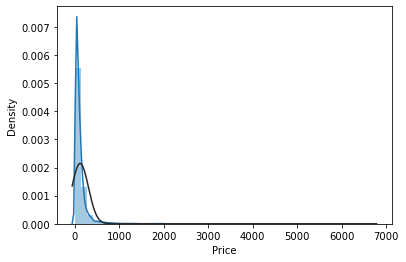

In [40]:
#distribution plot of Price column
from scipy.stats import norm
sns.distplot(df2.Price, fit = norm)

In [41]:
#drop rows where Price is more than 400
df2.drop(df2.loc[df2.Price > 400].index, inplace = True)

<AxesSubplot:xlabel='Price', ylabel='Density'>

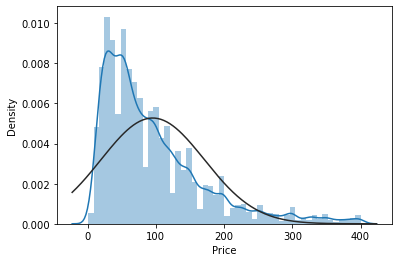

In [42]:
sns.distplot(df2.Price, fit = norm)

In [43]:
df2.shape

(87313, 34)

<AxesSubplot:xlabel='Number_Order_Item', ylabel='Density'>

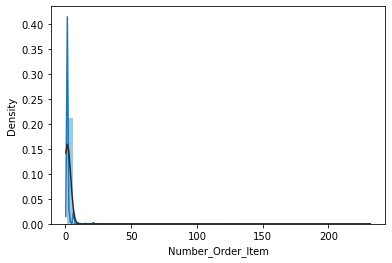

In [44]:
#distribution plot of Number_Order_Item column
sns.distplot(df2.Number_Order_Item, fit = norm)

In [45]:
#drop rows where Number_Order_Item is more than 10
df2.drop(df2.loc[df2.Number_Order_Item > 10].index, inplace = True)

<AxesSubplot:xlabel='Number_Order_Item', ylabel='Density'>

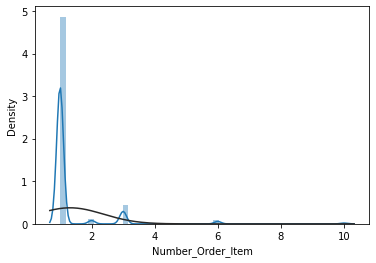

In [46]:
#distribution plot of Number_Order_Item column
sns.distplot(df2.Number_Order_Item, fit = norm)

In [47]:
df2.shape

(86813, 34)

<AxesSubplot:xlabel='Freight_Value', ylabel='Density'>

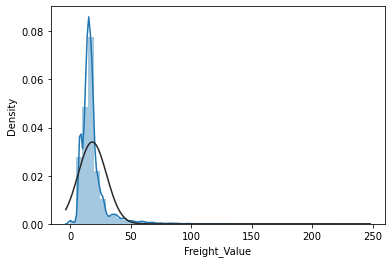

In [48]:
#distribution plot of Number_Order_Item column
sns.distplot(df2.Freight_Value, fit = norm)

In [49]:
#drop rows where Freight_Value is more than 30
df2.drop(df2.loc[df2.Freight_Value > 100].index, inplace = True)

<AxesSubplot:xlabel='Freight_Value', ylabel='Density'>

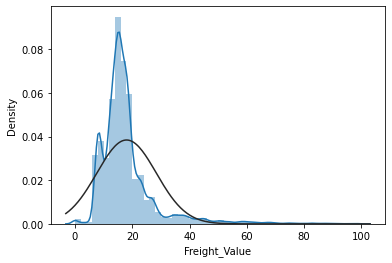

In [50]:
#distribution plot of Freight_Value column
sns.distplot(df2.Freight_Value, fit = norm)

In [51]:
df2.shape

(86617, 34)

<AxesSubplot:xlabel='Payment_Value', ylabel='Density'>

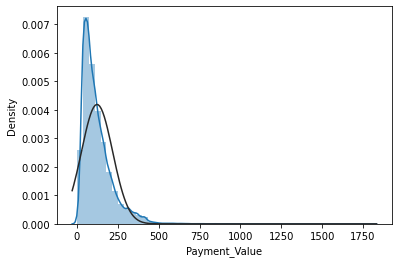

In [52]:
#distribution plot of Payment_Value column
sns.distplot(df2.Payment_Value, fit = norm)

In [53]:
#drop rows where Payment_Value is more than 500
df2.drop(df2.loc[df2.Payment_Value > 500].index, inplace = True)

<AxesSubplot:xlabel='Payment_Value', ylabel='Density'>

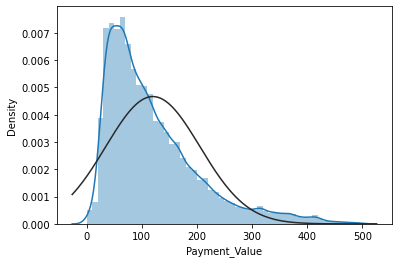

In [54]:
#distribution plot of Payment_Value column
sns.distplot(df2.Payment_Value, fit = norm)

In [55]:
df2.shape

(86183, 34)

### Exploratory Analysis 

In [56]:
df2.describe()

,Number_Order_Item,Price,Freight_Value,Payment_Installments,Payment_Sequential,Payment_Value,Customer_City_Code,Customer_State_Code,Order_Id_Code,Customer_Unique_Id_Code,...,Order_Status_Code_1,Order_Status_Code_2,Order_Status_Code_3,Order_Status_Code_4,Order_Status_Code_5,Order_Status_Code_6,Payment_Type_Code_1,Payment_Type_Code_2,Payment_Type_Code_3,Order_Date
count,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,...,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,8.618300e+04
mean,1.296451,94.580745,17.966275,2.740123,1.019598,119.958479,1936.435225,8.310270,45430.259297,43949.520613,...,0.004374,0.979068,0.002994,0.002738,0.010745,0.000058,0.757412,0.015711,0.027697,4.545263e+06
std,0.998577,74.685264,10.280747,2.530684,0.174554,85.466129,973.989621,3.182678,26247.573785,25345.001975,...,0.065995,0.143158,0.054632,0.052258,0.103098,0.007617,0.428651,0.124355,0.164104,3.723126e+06
min,1.000000,0.850000,0.000000,0.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.120180e+05
25%,1.000000,39.900000,12.800000,1.000000,1.000000,57.340000,1077.000000,6.000000,22703.500000,21996.500000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.032017e+06
50%,1.000000,72.000000,15.790000,1.000000,1.000000,96.650000,2275.000000,9.000000,45425.000000,43932.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.132018e+06
75%,1.000000,127.000000,19.320000,4.000000,1.000000,158.740000,2895.000000,11.000000,68172.500000,65879.500000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.262017e+06
max,10.000000,400.000000,99.880000,24.000000,8.000000,499.400000,3326.000000,11.000000,90867.000000,87891.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.231202e+07


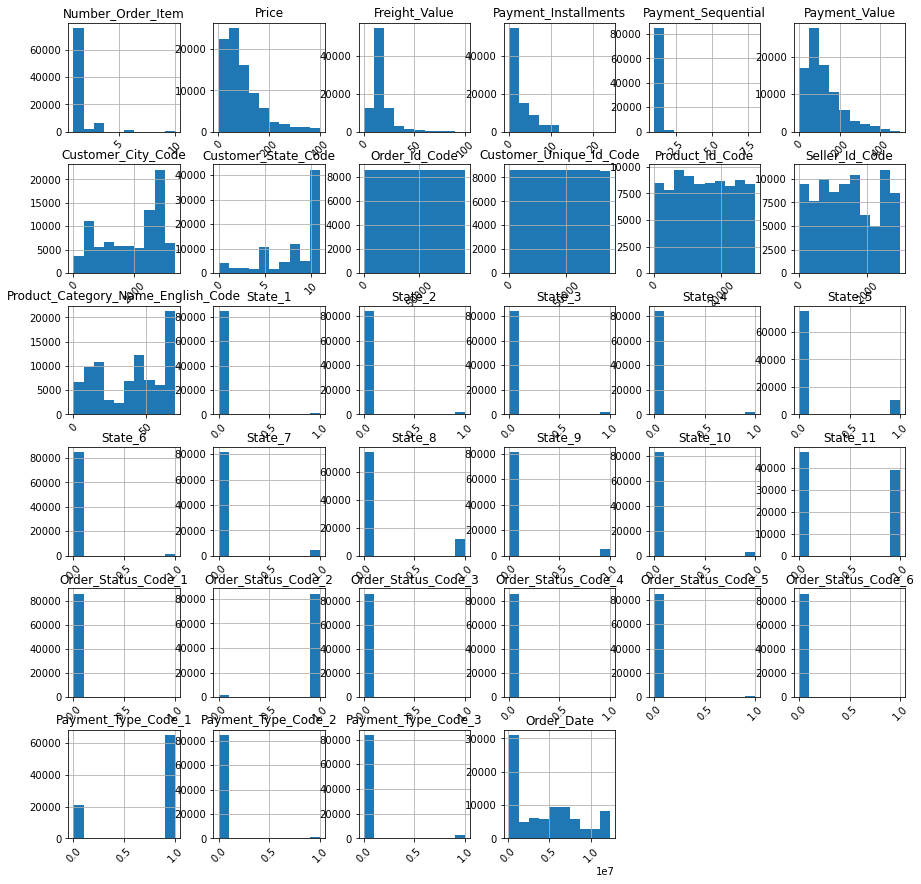

In [57]:
df2.hist(figsize = (15,15), xrot = 45)
plt.show()

In [58]:
df2_corr= df2.corr().abs()
df2_corr


,Number_Order_Item,Price,Freight_Value,Payment_Installments,Payment_Sequential,Payment_Value,Customer_City_Code,Customer_State_Code,Order_Id_Code,Customer_Unique_Id_Code,...,Order_Status_Code_1,Order_Status_Code_2,Order_Status_Code_3,Order_Status_Code_4,Order_Status_Code_5,Order_Status_Code_6,Payment_Type_Code_1,Payment_Type_Code_2,Payment_Type_Code_3,Order_Date
Number_Order_Item,1.000000,0.110555,0.036580,0.046341,0.209845,0.176956,0.004940,0.009189,0.002590,0.006936,...,0.005064,0.011428,0.001811,0.001787,0.014710,0.000790,0.038008,0.013679,0.137323,0.002480
Price,0.110555,1.000000,0.365255,0.335108,0.002430,0.892125,0.017335,0.045209,0.007973,0.006299,...,0.008624,0.017425,0.014983,0.017966,0.001213,0.005626,0.080027,0.016785,0.035121,0.006389
Freight_Value,0.036580,0.365255,1.000000,0.177907,0.010788,0.434557,0.085919,0.277752,0.003041,0.001117,...,0.003307,0.009001,0.001398,0.005514,0.012839,0.001466,0.020919,0.013535,0.008100,0.004434
Payment_Installments,0.046341,0.335108,0.177907,1.000000,0.070135,0.367504,0.027792,0.059622,0.003644,0.001743,...,0.001388,0.007713,0.000248,0.009593,0.004876,0.002588,0.389147,0.086872,0.116054,0.000729
Payment_Sequential,0.209845,0.002430,0.010788,0.070135,1.000000,0.087427,0.002355,0.010465,0.002143,0.003105,...,0.003638,0.001693,0.001148,0.005565,0.003319,0.000855,0.178226,0.006128,0.596762,0.002013
Payment_Value,0.176956,0.892125,0.434557,0.367504,0.087427,1.000000,0.024509,0.071830,0.004008,0.002484,...,0.006056,0.012208,0.013123,0.015707,0.002254,0.005578,0.087524,0.017573,0.100214,0.005377
Customer_City_Code,0.004940,0.017335,0.085919,0.027792,0.002355,0.024509,1.000000,0.263339,0.000834,0.006797,...,0.002879,0.003673,0.003635,0.001270,0.000977,0.004962,0.007417,0.009740,0.005735,0.001028
Customer_State_Code,0.009189,0.045209,0.277752,0.059622,0.010465,0.071830,0.263339,1.000000,0.004317,0.003290,...,0.011658,0.006844,0.009673,0.003263,0.023810,0.001172,0.007529,0.016151,0.011611,0.004853
Order_Id_Code,0.002590,0.007973,0.003041,0.003644,0.002143,0.004008,0.000834,0.004317,1.000000,0.002308,...,0.001825,0.004053,0.002254,0.003454,0.004489,0.007094,0.002208,0.002688,0.006754,0.005814
Customer_Unique_Id_Code,0.006936,0.006299,0.001117,0.001743,0.003105,0.002484,0.006797,0.003290,0.002308,1.000000,...,0.000705,0.002799,0.000681,0.001053,0.003503,0.003798,0.008065,0.004190,0.002322,0.002154


<AxesSubplot:>

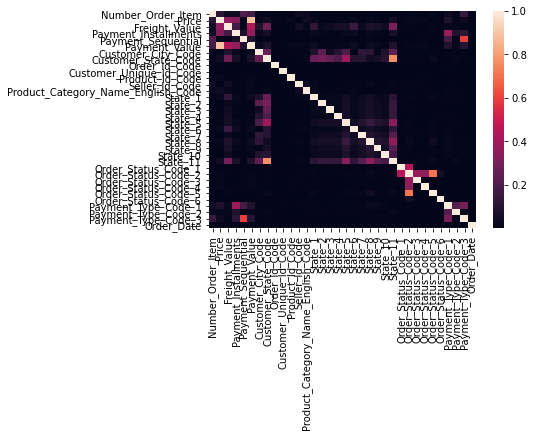

In [59]:
sns.heatmap(df2_corr.abs(), xticklabels=df2.columns, yticklabels=df2.columns)

In [60]:
#create a brief summary table for the dataset
pd.DataFrame([{'products': len(df2['Product_Id_Code'].value_counts()),
               'products_category': len(df2['Product_Category_Name_English_Code'].value_counts()),
               'transactions': len(df2['Order_Id_Code']),
               'customers': len(df2['Customer_Unique_Id_Code'].value_counts()), 
               'seller' : len(df2['Seller_Id_Code'].value_counts()),
               'customer_city': df2['Customer_City_Code'].nunique(),  
               'customer_state': df2['Customer_State_Code'].nunique(),   
              }], columns = ['products','products_category', 'transactions', 'customers','seller','customer_city','customer_state'], 
             index = ['quantity'])

,products,products_category,transactions,customers,seller,customer_city,customer_state
quantity,27917,71,86183,83418,2830,3285,12


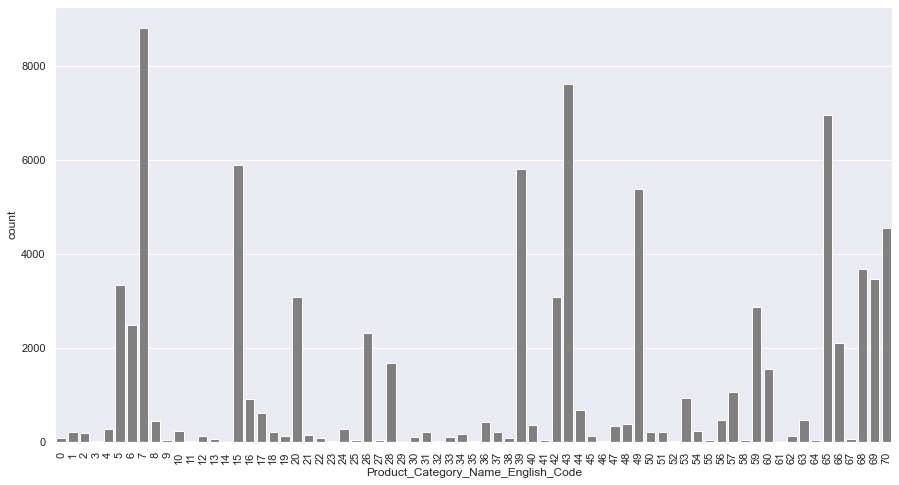

In [61]:
#which category is more popular than other?
sns.set(rc = {'figure.figsize':(15,8)})
category_plt = sns.countplot(df2['Product_Category_Name_English_Code'], color='gray')
category_plt.tick_params(axis='x', rotation=90)

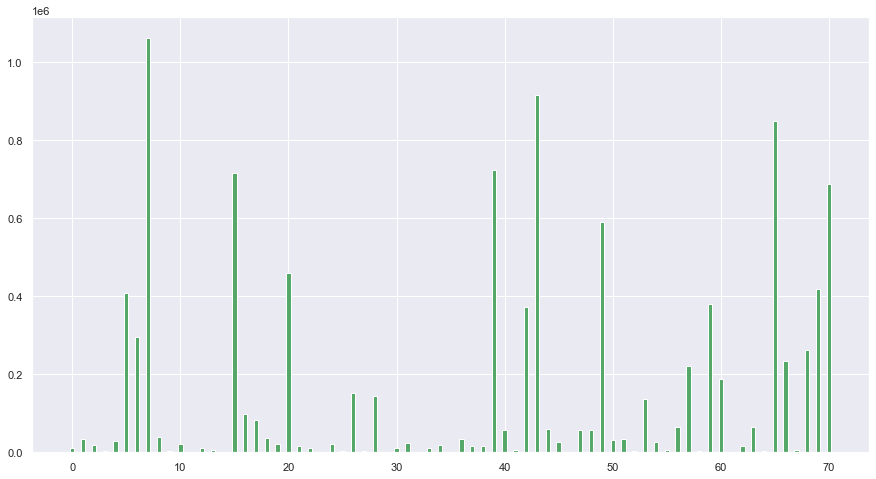

In [62]:
#which product category contribute to the revenue the most?
sum_money_cat = df2.groupby(['Product_Category_Name_English_Code']).Payment_Value.sum().reset_index()

plt.bar(sum_money_cat.Product_Category_Name_English_Code,sum_money_cat.Payment_Value, color ='g',width = 0.4)
plt.show()

In [63]:
#who are the most valuabale customer?
top_cust = df2.sort_values('Payment_Value',ascending = False)
top_cust['Payment_Type'] = df['Payment_Type']
top_cust[['Customer_Unique_Id_Code','Payment_Value','Product_Category_Name_English_Code','Customer_State_Code','Payment_Type']].head(10)

,Customer_Unique_Id_Code,Payment_Value,Product_Category_Name_English_Code,Customer_State_Code,Payment_Type
86014,56208,499.40,15,11,credit_card
56002,20672,498.79,49,11,credit_card
42802,52683,498.20,15,11,credit_card
59667,24246,498.04,57,11,credit_card
25825,3396,497.89,65,11,boleto
100748,66449,497.74,5,7,credit_card
96404,76333,497.62,5,2,voucher
93694,80518,497.52,15,11,credit_card
81548,84915,497.47,57,8,credit_card
26796,38151,497.07,49,11,credit_card


### Customer Segment with Feature Selection, Feature Scaling and Transformation

#### Manually selected features 

In [64]:
manual_feature=df2
manual_feature.columns

Index(['Number_Order_Item', 'Price', 'Freight_Value', 'Payment_Installments',
       'Payment_Sequential', 'Payment_Value', 'Customer_City_Code',
       'Customer_State_Code', 'Order_Id_Code', 'Customer_Unique_Id_Code',
       'Product_Id_Code', 'Seller_Id_Code',
       'Product_Category_Name_English_Code', 'State_1', 'State_2', 'State_3',
       'State_4', 'State_5', 'State_6', 'State_7', 'State_8', 'State_9',
       'State_10', 'State_11', 'Order_Status_Code_1', 'Order_Status_Code_2',
       'Order_Status_Code_3', 'Order_Status_Code_4', 'Order_Status_Code_5',
       'Order_Status_Code_6', 'Payment_Type_Code_1', 'Payment_Type_Code_2',
       'Payment_Type_Code_3', 'Order_Date'],
      dtype='object')

In [65]:
manual_feature.describe()

,Number_Order_Item,Price,Freight_Value,Payment_Installments,Payment_Sequential,Payment_Value,Customer_City_Code,Customer_State_Code,Order_Id_Code,Customer_Unique_Id_Code,...,Order_Status_Code_1,Order_Status_Code_2,Order_Status_Code_3,Order_Status_Code_4,Order_Status_Code_5,Order_Status_Code_6,Payment_Type_Code_1,Payment_Type_Code_2,Payment_Type_Code_3,Order_Date
count,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,...,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,86183.000000,8.618300e+04
mean,1.296451,94.580745,17.966275,2.740123,1.019598,119.958479,1936.435225,8.310270,45430.259297,43949.520613,...,0.004374,0.979068,0.002994,0.002738,0.010745,0.000058,0.757412,0.015711,0.027697,4.545263e+06
std,0.998577,74.685264,10.280747,2.530684,0.174554,85.466129,973.989621,3.182678,26247.573785,25345.001975,...,0.065995,0.143158,0.054632,0.052258,0.103098,0.007617,0.428651,0.124355,0.164104,3.723126e+06
min,1.000000,0.850000,0.000000,0.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.120180e+05
25%,1.000000,39.900000,12.800000,1.000000,1.000000,57.340000,1077.000000,6.000000,22703.500000,21996.500000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.032017e+06
50%,1.000000,72.000000,15.790000,1.000000,1.000000,96.650000,2275.000000,9.000000,45425.000000,43932.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.132018e+06
75%,1.000000,127.000000,19.320000,4.000000,1.000000,158.740000,2895.000000,11.000000,68172.500000,65879.500000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.262017e+06
max,10.000000,400.000000,99.880000,24.000000,8.000000,499.400000,3326.000000,11.000000,90867.000000,87891.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.231202e+07


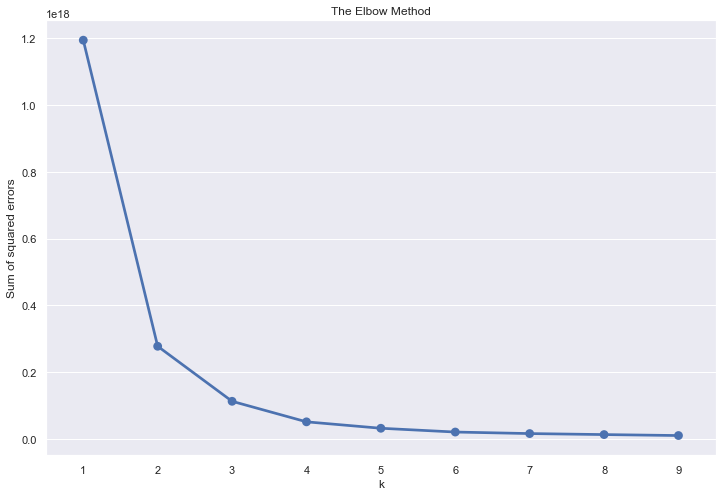

In [66]:
findElbow(manual_feature)

In [67]:
miniBatchKM(4,manual_feature,'None','None')

Mini Batch kmeans, 4 clusters: ,  calinski_harabaz_score 633510.7126514543 silhouette_score 0.6820866161945234 



In [68]:
kmeans(4,manual_feature,'None','None')

kmeans, 4 clusters: ,  calinski_harabaz_score 640363.13893732 silhouette_score 0.6829624004977193 



array([2, 3, 1, ..., 2, 0, 1])

In [69]:
kmeans(4,standardScaler(manual_feature),'None','Standard Scaler')

kmeans, 4 clusters: ,  calinski_harabaz_score 4686.317617467301 silhouette_score 0.11660002997385535 



array([0, 2, 0, ..., 2, 2, 2])

In [70]:
miniBatchKM(4,standardScaler(manual_feature),'None','Standard Scaler')

Mini Batch kmeans, 4 clusters: ,  calinski_harabaz_score 3148.5990532165847 silhouette_score -0.039081644462064975 



### Variance Threshold 

In [71]:
df3 = df2.select_dtypes(include = np.number)
df3

,Number_Order_Item,Price,Freight_Value,Payment_Installments,Payment_Sequential,Payment_Value,Customer_City_Code,Customer_State_Code,Order_Id_Code,Customer_Unique_Id_Code,...,Order_Status_Code_1,Order_Status_Code_2,Order_Status_Code_3,Order_Status_Code_4,Order_Status_Code_5,Order_Status_Code_6,Payment_Type_Code_1,Payment_Type_Code_2,Payment_Type_Code_3,Order_Date
0,1,58.90,13.29,2,1,72.19,578,8,0,46445,...,0,1,0,0,0,0,1,0,0,9132017
1,1,239.90,19.93,3,1,259.83,2645,11,1,80875,...,0,1,0,0,0,0,1,0,0,4262017
2,1,199.00,17.87,5,1,216.87,2146,5,2,19329,...,0,1,0,0,0,0,1,0,0,1142018
3,1,12.99,12.79,2,1,25.78,255,11,3,60376,...,0,1,0,0,0,0,1,0,0,882018
4,1,199.90,18.14,3,1,218.04,3251,11,4,34638,...,0,1,0,0,0,0,1,0,0,242017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117595,1,119.85,20.03,3,1,139.88,1920,5,90863,81410,...,0,1,0,0,0,0,1,0,0,6192018
117597,1,350.00,36.53,1,1,386.53,902,7,90864,4729,...,0,1,0,0,0,0,0,0,0,7142018
117598,1,99.90,16.95,3,1,116.85,2895,11,90865,70628,...,0,1,0,0,0,0,1,0,0,10232017
117599,1,55.99,8.72,3,1,64.71,3292,11,90866,80992,...,0,1,0,0,0,0,1,0,0,8142017


In [72]:
vt_feature = VarianceThreshold(threshold= 0.5)
vt_feature.fit(df3)
pd.DataFrame({'Variance': vt_feature.variances_, 'select_status':vt_feature.get_support()}, index= df3.columns)

,Variance,select_status
Number_Order_Item,9.971454e-01,True
Price,5.577824e+03,True
Freight_Value,1.056925e+02,True
Payment_Installments,6.404285e+00,True
Payment_Sequential,3.046888e-02,False
Payment_Value,7.304374e+03,True
Customer_City_Code,9.486448e+05,True
Customer_State_Code,1.012932e+01,True
Order_Id_Code,6.889271e+08,True
Customer_Unique_Id_Code,6.423617e+08,True


In [73]:
df_vt  =df3.iloc[:,vt_feature.get_support()]
df_vt.head()

,Number_Order_Item,Price,Freight_Value,Payment_Installments,Payment_Value,Customer_City_Code,Customer_State_Code,Order_Id_Code,Customer_Unique_Id_Code,Product_Id_Code,Seller_Id_Code,Product_Category_Name_English_Code,Order_Date
0,1,58.90,13.29,2,72.19,578,8,0,46445,7896,823,20,9132017
1,1,239.90,19.93,3,259.83,2645,11,1,80875,26976,2573,60,4262017
2,1,199.00,17.87,5,216.87,2146,5,2,19329,23387,1076,39,1142018
3,1,12.99,12.79,2,25.78,255,11,3,60376,14010,1844,59,882018
4,1,199.90,18.14,3,218.04,3251,11,4,34638,20148,2592,42,242017


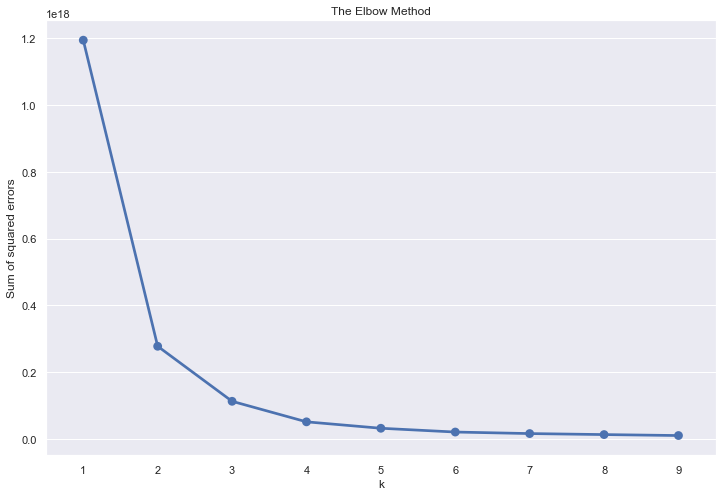

In [74]:
findElbow(df_vt)

In [75]:
kmeans(4,df_vt,'Variance Threshold', 'None')

kmeans, 4 clusters: ,  calinski_harabaz_score 640363.1389384101 silhouette_score 0.6829624004993778 



array([2, 3, 1, ..., 2, 0, 1])

In [76]:
kmeans(4,standardScaler(df_vt),'Variance Threshold', 'Standard Scaler')

kmeans, 4 clusters: ,  calinski_harabaz_score 8333.690077940719 silhouette_score 0.09388643136589306 



array([3, 0, 0, ..., 1, 1, 3])

In [77]:
miniBatchKM(4,standardScaler(df_vt),'Variance Threshold', 'Standard Scaler')

Mini Batch kmeans, 4 clusters: ,  calinski_harabaz_score 7767.411077811109 silhouette_score 0.08957972094395909 



In [78]:
miniBatchKM(4,df_vt,'Variance Threshold', 'None')

Mini Batch kmeans, 4 clusters: ,  calinski_harabaz_score 633510.7126525216 silhouette_score 0.6820866161961208 



### RFM Segmentation

In [79]:
df_rfm = pd.concat([df_vt, df.Order_Purchase_Timestamp], axis=1, join='inner')
df_rfm

,Number_Order_Item,Price,Freight_Value,Payment_Installments,Payment_Value,Customer_City_Code,Customer_State_Code,Order_Id_Code,Customer_Unique_Id_Code,Product_Id_Code,Seller_Id_Code,Product_Category_Name_English_Code,Order_Date,Order_Purchase_Timestamp
0,1,58.90,13.29,2,72.19,578,8,0,46445,7896,823,20,9132017,9/13/2017 8:59
1,1,239.90,19.93,3,259.83,2645,11,1,80875,26976,2573,60,4262017,4/26/2017 10:53
2,1,199.00,17.87,5,216.87,2146,5,2,19329,23387,1076,39,1142018,1/14/2018 14:33
3,1,12.99,12.79,2,25.78,255,11,3,60376,14010,1844,59,882018,8/8/2018 10:00
4,1,199.90,18.14,3,218.04,3251,11,4,34638,20148,2592,42,242017,2/4/2017 13:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117595,1,119.85,20.03,3,139.88,1920,5,90863,81410,13102,379,48,6192018,6/19/2018 9:27
117597,1,350.00,36.53,1,386.53,902,7,90864,4729,6053,2835,15,7142018,7/14/2018 10:26
117598,1,99.90,16.95,3,116.85,2895,11,90865,70628,13573,2271,65,10232017,10/23/2017 17:07
117599,1,55.99,8.72,3,64.71,3292,11,90866,80992,18325,491,15,8142017,8/14/2017 23:02


In [80]:
all_dates = (pd.to_datetime(df_rfm['Order_Purchase_Timestamp'])).apply(lambda x:x.date())


In [81]:
(all_dates.max() - all_dates.min()).days

729

In [82]:
# Start and end dates:
print('Start date: {}'.format(all_dates.min()))
print('End date: {}'.format(all_dates.max()))

Start date: 2016-09-04
End date: 2018-09-03


In [83]:
latest_date = dt.datetime(2018,9,4)

In [84]:
df_rfm.Order_Purchase_Timestamp = pd.to_datetime(df_rfm.Order_Purchase_Timestamp)

In [85]:
rfm_score = df_rfm.groupby(['Customer_Unique_Id_Code'],as_index=False).agg({'Order_Purchase_Timestamp': lambda x: (latest_date - x.max()).days,
                                             'Number_Order_Item': 'count',
                                             'Payment_Value': 'sum'}).rename(columns = {'Order_Purchase_Timestamp': 'Recency',
                                                                                   'Number_Order_Item': 'Frequency',
                                                                                   'Payment_Value': 'MonetaryValue'})

In [86]:
rfm_score.describe()

,Customer_Unique_Id_Code,Recency,Frequency,MonetaryValue
count,83418.000000,83418.000000,83418.000000,83418.000000
mean,43942.005886,244.181783,1.033146,123.934662
std,25357.171044,153.127221,0.207203,90.814566
min,0.000000,0.000000,1.000000,0.010000
25%,21965.250000,120.000000,1.000000,58.170000
50%,43938.500000,224.000000,1.000000,98.970000
75%,65890.750000,353.000000,1.000000,163.107500
max,87891.000000,729.000000,15.000000,1172.660000


In [87]:
quantiles = rfm_score.quantile(q= [0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [88]:
quantiles

{'Customer_Unique_Id_Code': {0.25: 21965.25, 0.5: 43938.5, 0.75: 65890.75},
 'Recency': {0.25: 120.0, 0.5: 224.0, 0.75: 353.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'MonetaryValue': {0.25: 58.17, 0.5: 98.97, 0.75: 163.10750000000002}}

In [89]:
r_labels = range(4, 0, -1)
f_labels = range(1,5)
m_labels = range(1,5)

r_quantiles = pd.qcut(rfm_score['Recency'], 4, labels = r_labels)
f_quantiles = pd.cut(rfm_score['Frequency'], 4, labels = f_labels)
m_quantiles = pd.qcut(rfm_score['MonetaryValue'], 4, labels = m_labels)

rfm_score = rfm_score.assign(R = r_quantiles.values)
rfm_score = rfm_score.assign(F = f_quantiles.values)
rfm_score = rfm_score.assign(M = m_quantiles.values)
rfm_score.head()

,Customer_Unique_Id_Code,Recency,Frequency,MonetaryValue,R,F,M
0,0,119,1,141.90,4,1,3
1,1,228,1,27.19,2,1,1
2,2,162,1,86.22,3,1,2
3,3,410,1,196.89,1,1,4
4,4,237,1,166.98,2,1,4


In [90]:
rfm_score['R'] = rfm_score.R.astype(int)
rfm_score['F'] = rfm_score.F.astype(int)
rfm_score['M'] = rfm_score.M.astype(int)

In [91]:
# rfm_score['RFM_Segment'] = str(rfm_score['R'])+str(rfm_score['F'])+str(rfm_score['M'])
# rfm_score['RFM_Segment'] = [str(rfm_score['R']),str(rfm_score['F'])+str(rfm_score['M'])].join('')
rfm_score['RFM_Segment'] = rfm_score['R'].map(str)+rfm_score['F'].map(str)+rfm_score['M'].map(str)


rfm_score['RFM_Score'] = rfm_score[['R','F','M']].sum(axis=1)
rfm_score.head()

,Customer_Unique_Id_Code,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
0,0,119,1,141.90,4,1,3,413,8
1,1,228,1,27.19,2,1,1,211,4
2,2,162,1,86.22,3,1,2,312,6
3,3,410,1,196.89,1,1,4,114,6
4,4,237,1,166.98,2,1,4,214,7


In [92]:
rfm_score.groupby('RFM_Score').agg({'Recency': 'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue       
             mean      mean          mean  count
RFM_Score                                       
3           457.7       1.0          39.7   5339
4           371.1       1.0          58.6  10555
5           305.1       1.0          81.6  15516
6           244.4       1.0         123.0  20473
7           171.9       1.0         150.0  15532
8           118.5       1.1         190.7  10681
9            63.1       1.2         253.9   5311
10           43.9       5.7         772.4      9
11           67.0      12.0         996.4      2

In [93]:
rfm_score['Customer_Segment'] = rfm_score.apply(create_customer_segment, axis =1)
rfm_score.groupby('Customer_Segment').agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue       
                    mean      mean          mean  count
Customer_Segment                                       
High                63.0       1.2         255.0   5322
Low                400.2       1.0          52.3  15894
Middle             219.8       1.0         131.0  62202

In [94]:
rfm_data = rfm_score[['Recency','Frequency','MonetaryValue']]

In [95]:
# Unskew the data
data_log = np.log(rfm_data)
data_log.replace([np.inf, -np.inf], np.nan, inplace=True)
data_log.dropna(inplace =True)

In [96]:
data_norm = standardScaler(data_log)

In [97]:
data_norm

,Recency,Frequency,MonetaryValue
0,-0.492056,-0.172313,0.520522
1,0.247967,-0.172313,-1.694135
2,-0.140981,-0.172313,-0.147278
3,0.915822,-0.172313,0.959523
4,0.292028,-0.172313,0.738669
...,...,...,...
83412,0.410498,-0.172313,-0.227682
83413,0.962059,-0.172313,-0.367438
83414,0.654899,-0.172313,-0.173019
83415,-0.002257,-0.172313,0.440637


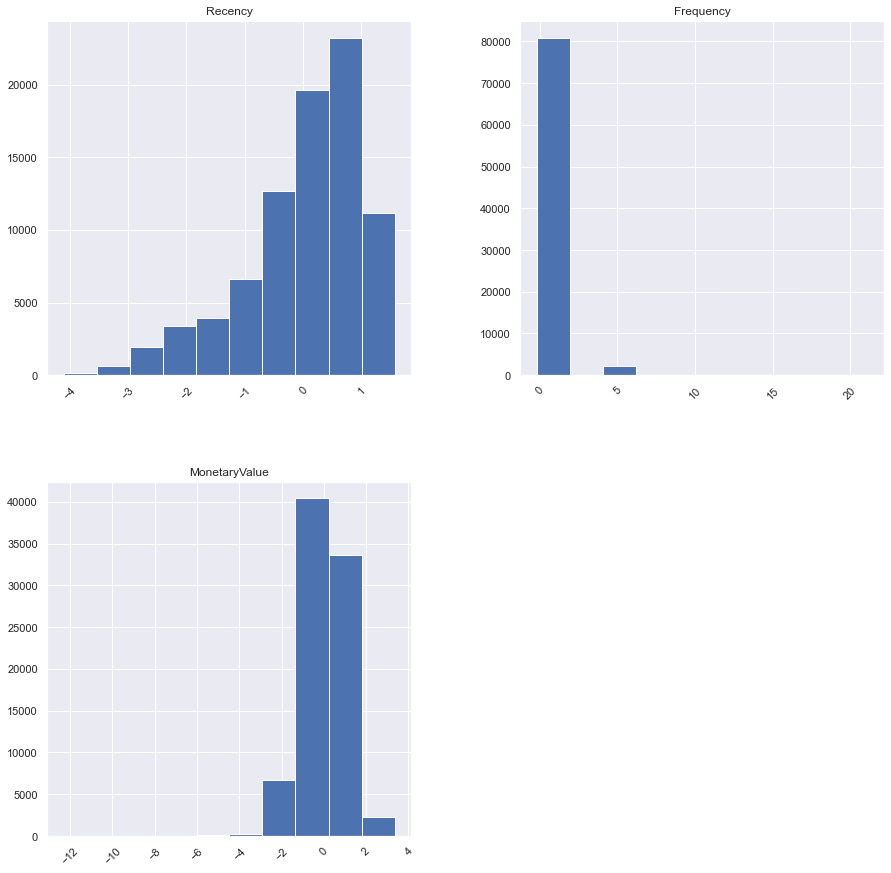

In [98]:
data_norm.hist(figsize = (15,15), xrot = 45)
plt.show()

In [99]:
data_norm.dropna(inplace = True)

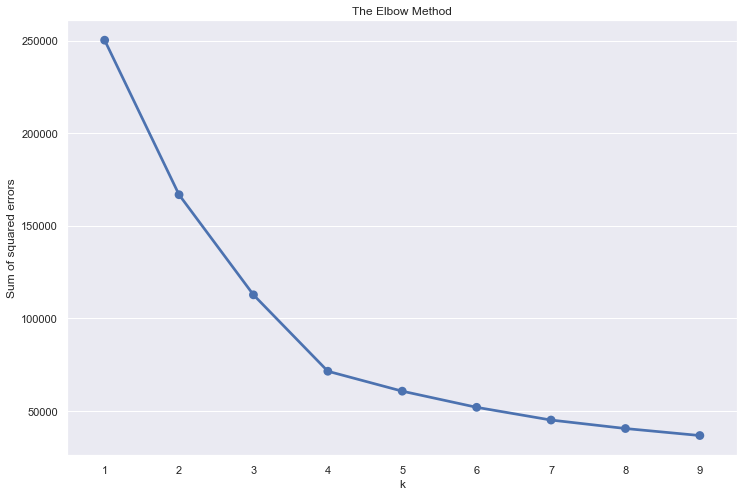

In [100]:
findElbow(data_norm)

In [101]:
kmeans(4,data_norm,'Variance Threshold-RFM','Log')

kmeans, 4 clusters: ,  calinski_harabaz_score 69734.21545248528 silhouette_score 0.4014632519671934 



array([3, 1, 1, ..., 1, 3, 1])

In [102]:
kmeans(4,rfm_data,'Variance Threshold-RFM','None')

kmeans, 4 clusters: ,  calinski_harabaz_score 84442.83157967664 silhouette_score 0.4082952527537683 



array([1, 0, 1, ..., 0, 0, 2])

In [103]:
miniBatchKM(4,data_norm,'Variance Threshold-RFM','Log')

Mini Batch kmeans, 4 clusters: ,  calinski_harabaz_score 68863.01366980493 silhouette_score 0.3963628314852848 



In [104]:
miniBatchKM(4,rfm_data,'Variance Threshold-RFM','None')

Mini Batch kmeans, 4 clusters: ,  calinski_harabaz_score 84157.62893923932 silhouette_score 0.40819455229624496 



### Interpret best model

In [105]:
#combine and sort all the performance indicator from all the models
final_result = pd.DataFrame(zip(feature_selection,feature_transformation,model_used,calinski_harabasz_score_lst,silhouette_score_lst),columns 
                            = ['Feature Selection','Feature Transformation','Model','Calinski Harabasz score','Silhouette Score'])
final_result.sort_values(ascending = False, by = ['Silhouette Score'])

,Feature Selection,Feature Transformation,Model,Calinski Harabasz score,Silhouette Score
4,Variance Threshold,None,"Kmean, k =4",640363.138938,0.682962
1,None,None,"Kmean, k =4",640363.138937,0.682962
7,Variance Threshold,None,"Mini Batch Kmean, k =4",633510.712653,0.682087
0,None,None,"Mini Batch Kmean, k =4",633510.712651,0.682087
9,Variance Threshold-RFM,None,"Kmean, k =4",84442.831580,0.408295
11,Variance Threshold-RFM,None,"Mini Batch Kmean, k =4",84157.628939,0.408195
8,Variance Threshold-RFM,Log,"Kmean, k =4",69734.215452,0.401463
10,Variance Threshold-RFM,Log,"Mini Batch Kmean, k =4",68863.013670,0.396363
2,None,Standard Scaler,"Kmean, k =4",4686.317617,0.116600
5,Variance Threshold,Standard Scaler,"Kmean, k =4",8333.690078,0.093886


In [106]:
#take the cluster label of the best model
k_label = kmeans(4,df_vt,'Variance Threshold', 'None')

kmeans, 4 clusters: ,  calinski_harabaz_score 640363.1389384101 silhouette_score 0.6829624004993778 



In [107]:
k_cluster_data = df_vt.assign(Cluster = k_label)
k_cluster_data

,Number_Order_Item,Price,Freight_Value,Payment_Installments,Payment_Value,Customer_City_Code,Customer_State_Code,Order_Id_Code,Customer_Unique_Id_Code,Product_Id_Code,Seller_Id_Code,Product_Category_Name_English_Code,Order_Date,Cluster
0,1,58.90,13.29,2,72.19,578,8,0,46445,7896,823,20,9132017,2
1,1,239.90,19.93,3,259.83,2645,11,1,80875,26976,2573,60,4262017,0
2,1,199.00,17.87,5,216.87,2146,5,2,19329,23387,1076,39,1142018,1
3,1,12.99,12.79,2,25.78,255,11,3,60376,14010,1844,59,882018,1
4,1,199.90,18.14,3,218.04,3251,11,4,34638,20148,2592,42,242017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117595,1,119.85,20.03,3,139.88,1920,5,90863,81410,13102,379,48,6192018,3
117597,1,350.00,36.53,1,386.53,902,7,90864,4729,6053,2835,15,7142018,3
117598,1,99.90,16.95,3,116.85,2895,11,90865,70628,13573,2271,65,10232017,2
117599,1,55.99,8.72,3,64.71,3292,11,90866,80992,18325,491,15,8142017,3


In [108]:
#assign the cluster lable to the original data
df4 = pd.concat([df_vt, k_cluster_data.Cluster], axis=1, join='inner')
df4


,Number_Order_Item,Price,Freight_Value,Payment_Installments,Payment_Value,Customer_City_Code,Customer_State_Code,Order_Id_Code,Customer_Unique_Id_Code,Product_Id_Code,Seller_Id_Code,Product_Category_Name_English_Code,Order_Date,Cluster
0,1,58.90,13.29,2,72.19,578,8,0,46445,7896,823,20,9132017,2
1,1,239.90,19.93,3,259.83,2645,11,1,80875,26976,2573,60,4262017,0
2,1,199.00,17.87,5,216.87,2146,5,2,19329,23387,1076,39,1142018,1
3,1,12.99,12.79,2,25.78,255,11,3,60376,14010,1844,59,882018,1
4,1,199.90,18.14,3,218.04,3251,11,4,34638,20148,2592,42,242017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117595,1,119.85,20.03,3,139.88,1920,5,90863,81410,13102,379,48,6192018,3
117597,1,350.00,36.53,1,386.53,902,7,90864,4729,6053,2835,15,7142018,3
117598,1,99.90,16.95,3,116.85,2895,11,90865,70628,13573,2271,65,10232017,2
117599,1,55.99,8.72,3,64.71,3292,11,90866,80992,18325,491,15,8142017,3


In [109]:
#count number of cluster in the dataset
df4['Cluster'].value_counts()

1    36099
3    18163
0    17972
2    13949
Name: Cluster, dtype: int64

<AxesSubplot:xlabel='Cluster', ylabel='count'>

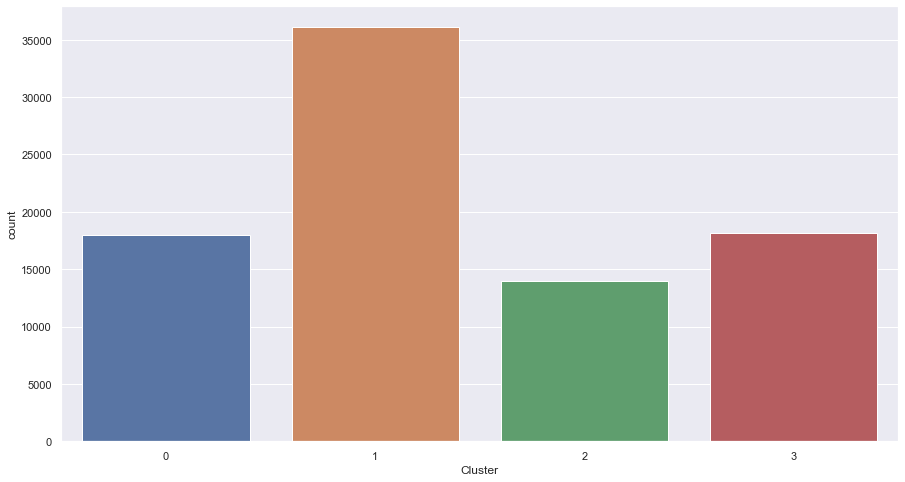

In [110]:
sns.countplot(x="Cluster", data=df4)

In [111]:
important_feature = df4[['Cluster','Number_Order_Item','Price','Payment_Value']]

In [112]:
#Let's look at some features of each cluster
important_feature.groupby(['Cluster'], as_index = False).mean()

,Cluster,Number_Order_Item,Price,Payment_Value
0,0,1.304418,94.863034,120.348793
1,1,1.288845,95.081988,120.316497
2,2,1.298158,94.129153,119.477810
3,3,1.302373,93.652021,119.229858


<AxesSubplot:xlabel='Customer_State_Code', ylabel='count'>

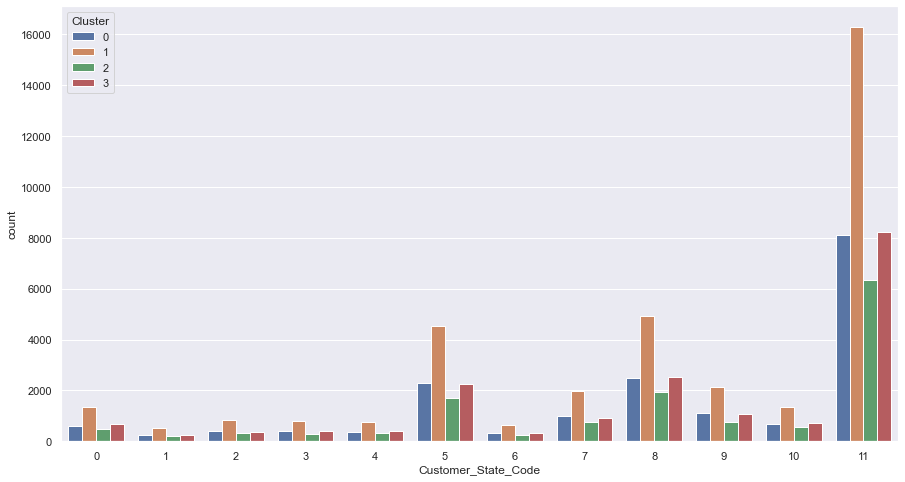

In [113]:
sns.countplot(x='Customer_State_Code', data=df4, hue='Cluster')

In [114]:
clus1_data = df4.loc[df4['Cluster'] ==1]
clus2_data = df4.loc[df4['Cluster'] ==2]
clus3_data = df4.loc[df4['Cluster'] ==3]
clus0_data = df4.loc[df4['Cluster'] ==0]

[Text(0.5, 1.0, 'Cluster 4')]

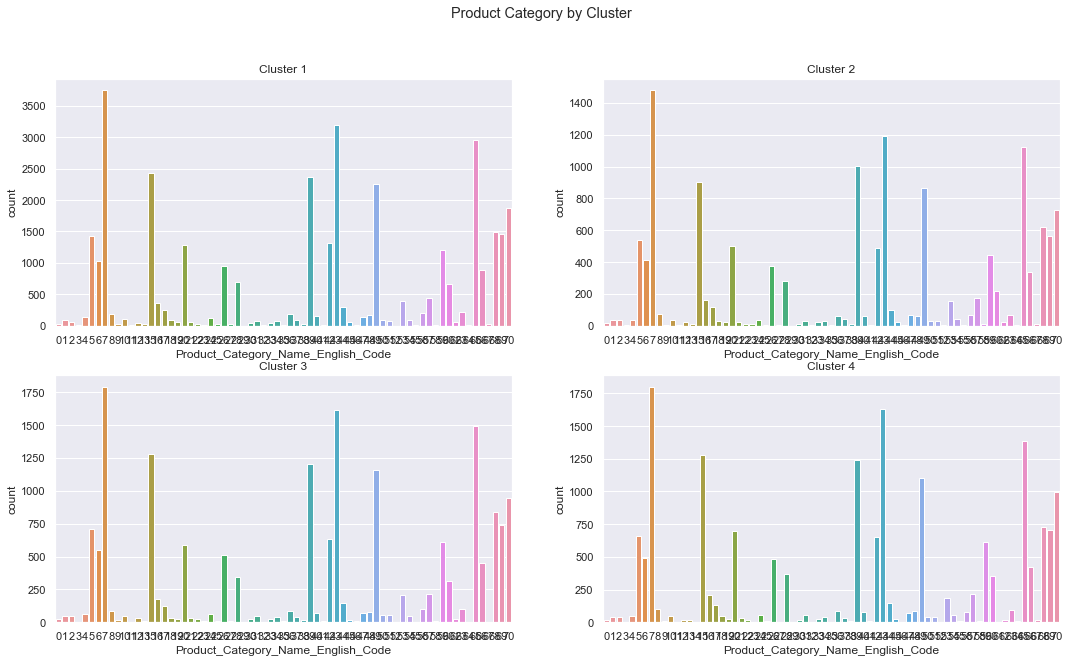

In [115]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Product Category by Cluster')

sns.countplot(ax =axes[0,0],x='Product_Category_Name_English_Code', data=clus1_data).set(title='Cluster 1')

sns.countplot(ax =axes[0,1],x='Product_Category_Name_English_Code', data=clus2_data).set(title='Cluster 2')

sns.countplot(ax =axes[1,0],x='Product_Category_Name_English_Code', data=clus3_data).set(title='Cluster 3')

sns.countplot(ax =axes[1,1],x='Product_Category_Name_English_Code', data=clus0_data).set(title='Cluster 4')
